# The best location to open the sub-saharian African Restaurant in Toronto !

### I. Introduction / Business Problem

Toronto is the capital city of the Canadian province of Ontario. With a recorded population of 2,731,571 in 2016. It is the most populous city in Canada and the fourth most populous city in North America. According to official statistics, Toronto is the city with the largest number of blacks in Canada (approximately 36%) and this proportion represents approximately 7.5% of the city's population.

Because of this multiculturalism, Toronto is full of many culinary treasures and therefore many restaurants. There are Portuguese, Japanese, Chinese, Vietnamese, Indian restaurants and more.
According to official statistics, Toronto is the city with the largest number of blacks in Canada (approximately 36%) and this proportion represents approximately 7.5% of the city's population.

In view of these elements, an investor wants to create a sub-saharan african restaurant in a neighborhood of the city of toronto.
the objective of this data science project is to be able to find the best location for setting up this restaurant.


Geographical coordinates of each neighbourhood: (https://cocl.us/Geospatial_data)


In [ ]:
url = https://www150.statcan.gc.ca/n1/pub/89-657-x/89-657-x2019002-fra.htm

### II. Data

The Foursquare API will be used to explore neighborhoods in Toronto, more specifically, we will be using the explore function to get the most common venue categories in each neighborhood.

Neighbourhood names, alongside their corresponding boroughs and postal codes, scraped from Wikipedia: (https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050)

The Toronto's census data for its social demographic characteristics will be distilled from Toronto's Neighborhood Profile (https://bit.ly/3airrOJ).


### III. Data Exploration

#### Import all the libraries wich we are needed in the project

For this project, we need several python libraries like Pandas, Numpy, for data manipulation, matplolib, Folium for graphical representations and maps, and Sklearn for neighborhood segmentation

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c conda-forge lxml --yes
import folium # map rendering library
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
print('libraries are imported')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

libraries are imported


### Load Census Data of Toronto

In [2]:
toronto_pop = pd.read_csv('wellbeing_toronto.csv')
toronto_pop = pd.DataFrame(toronto_pop)
toronto_pop.drop(['Neighbourhood Id', 'Combined Indicators'], axis=1, inplace=True)
toronto_pop.rename(columns={'After-Tax Household Income': 'Income'}, inplace=True)
toronto_pop.head()

,Neighbourhood,Income,Africa,Total Population
0,West Humber-Clairville,59703.0,260.0,33312.0
1,Mount Olive-Silverstone-Jamestown,46986.0,830.0,32954.0
2,Thistletown-Beaumond Heights,57522.0,130.0,10360.0
3,Rexdale-Kipling,51194.0,0.0,10529.0
4,Elms-Old Rexdale,49425.0,90.0,9456.0


### Load geospatial and Postal data of Toronto

In [3]:
geo_toronto = pd.read_csv('geospatial_coordinates.csv')
geo_toronto.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [4]:
post_toronto = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
post_toronto = pd.DataFrame(post_toronto)
post_toronto = post_toronto[post_toronto.Community!='Not assigned']
post_toronto.head()

,Postal Code,Community,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Build our Final Data Frame

In [5]:
toronto_data = pd.merge(geo_toronto, post_toronto, left_on='Postal Code', right_on='Postal Code').drop(['Postal Code', 'Postal Code', 'Community'], axis=1)
df = pd.merge(toronto_data, toronto_pop, on='Neighbourhood', how='right').dropna(how='any', axis=0).reset_index(drop=True)
df.head()

,Latitude,Longitude,Neighbourhood,Income,Africa,Total Population
0,43.756303,-79.565963,Humber Summit,53272.0,40.0,12416.0
1,43.725882,-79.315572,Victoria Village,43743.0,215.0,17510.0
2,43.803762,-79.363452,Hillcrest Village,57682.0,30.0,16934.0
3,43.786947,-79.385975,Bayview Village,58028.0,25.0,21396.0
4,43.705369,-79.349372,Thorncliffe Park,38645.0,230.0,21108.0


In [7]:
df['Percentage of Africans'] = (df['   Africa'] / df['Total Population'])*100
df.head()

,Latitude,Longitude,Neighbourhood,Income,Africa,Total Population,Percentage of Africans
0,43.756303,-79.565963,Humber Summit,53272.0,40.0,12416.0,0.322165
1,43.725882,-79.315572,Victoria Village,43743.0,215.0,17510.0,1.227870
2,43.803762,-79.363452,Hillcrest Village,57682.0,30.0,16934.0,0.177158
3,43.786947,-79.385975,Bayview Village,58028.0,25.0,21396.0,0.116844
4,43.705369,-79.349372,Thorncliffe Park,38645.0,230.0,21108.0,1.089634


#### Mapping Toronto using Folium library 

In [8]:
# Get location of Toronto
address = 'Toronto'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("The geographical coordinates of Toronto are {}, {}".format(latitude, longitude))

The geographical coordinates of Toronto are 43.6534817, -79.3839347


In [9]:
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
  label = '{}'.format(neighbourhood)
  label = folium.Popup(label)
  folium.CircleMarker(
      [lat,lng],
      radius=10,
      color='blue',
      popup=label,
      fill_color='#3186cc',
      fill_opacity=0.9,
      fill=True

  ).add_to(map_Toronto)

map_Toronto

### Explore the top 100 venues that are in Toronto using Foursquare API

In [10]:
# Get the credentials
CLIENT_ID = '14OTNVGNWLWIWIIOL2QBG2HWIOQIPFJMAJBH1XXRIREML0ZH' # your Foursquare ID
CLIENT_SECRET = 'MMT0XYYJNWPME2GQHYS5T4V2U05UKLHLTAGZQAZOJKHKJZUJ' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

In [11]:
LIMIT = 100
radius = 1500 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=14OTNVGNWLWIWIIOL2QBG2HWIOQIPFJMAJBH1XXRIREML0ZH&client_secret=MMT0XYYJNWPME2GQHYS5T4V2U05UKLHLTAGZQAZOJKHKJZUJ&v=20180604&ll=43.6534817,-79.3839347&radius=1500&limit=100'

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
toronto_venues.head()

Humber Summit
Victoria Village
Hillcrest Village
Bayview Village
Thorncliffe Park
The Beaches
Humewood-Cedarvale
Weston
Woburn
Scarborough Village


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Humber Summit,43.756303,-79.565963,Pizza Monza,43.755043,-79.567195,Pizza Place
1,Humber Summit,43.756303,-79.565963,HNS ARARAT,43.757519,-79.563653,Furniture / Home Store
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [14]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Bayview Village,4,4,4,4,4,4
Hillcrest Village,5,5,5,5,5,5
Humber Summit,2,2,2,2,2,2
Humewood-Cedarvale,4,4,4,4,4,4
Scarborough Village,3,3,3,3,3,3
The Beaches,4,4,4,4,4,4
Thorncliffe Park,24,24,24,24,24,24
Victoria Village,5,5,5,5,5,5
Weston,2,2,2,2,2,2


### Analyze Each Neighborhood

In [15]:
import requests
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighbourhood to column back to data frame
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']

# move neighbourhood column to the first column
cols = list(toronto_onehot)
cols.insert(0, cols.pop(cols.index('Neighbourhood')))
toronto_onehot = toronto_onehot.loc[:,cols]
toronto_onehot

,Neighbourhood,Athletics & Sports,Bank,Burger Joint,Bus Line,Café,Chinese Restaurant,Coffee Shop,Discount Store,Dog Run,...,Portuguese Restaurant,Pub,Restaurant,Sandwich Place,Smoke Shop,Supermarket,Tennis Court,Trail,Warehouse Store,Yoga Studio
0,Humber Summit,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Humber Summit,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Hillcrest Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Hillcrest Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Hillcrest Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
toronto_onehot['Restaurants'] = toronto_onehot['Restaurant']+toronto_onehot['Chinese Restaurant']+ toronto_onehot['Fast Food Restaurant']+toronto_onehot['Indian Restaurant']+toronto_onehot['Japanese Restaurant']+ toronto_onehot['Mediterranean Restaurant']+toronto_onehot['Mexican Restaurant']+toronto_onehot['Middle Eastern Restaurant']+toronto_onehot['Portuguese Restaurant']
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped = toronto_grouped[['Neighbourhood', 'Restaurants']]
toronto_grouped.set_index('Neighbourhood', inplace=True)

### Plot African population caracteristics in each Neighbourhood

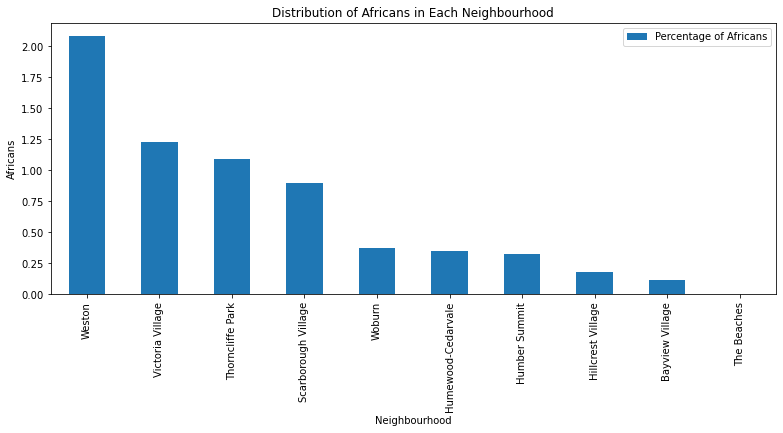

In [18]:
# Plot distribution of African population
df.head()
df_africa = df[['Neighbourhood', 'Percentage of Africans']].set_index('Neighbourhood')
df_africa.sort_values(by='Percentage of Africans', ascending=False, inplace=True)

#plot bar graph
df_africa.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Africans in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Africans')

plt.show()

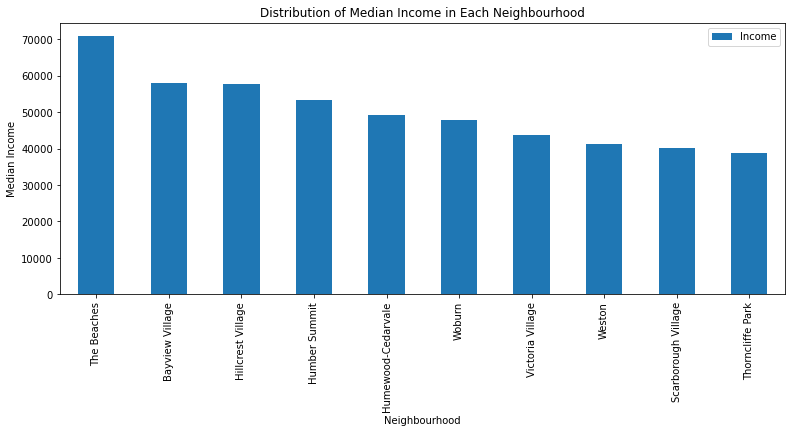

In [19]:
# Plot Distribution of Income 
df_income = df[['Neighbourhood', 'Income']].set_index('Neighbourhood')

# sort by descending order
df_income.sort_values(by='Income', ascending=False, inplace=True)

#plot bar graph
df_income.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Median Income in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Median Income')

plt.show()

Text(0, 0.5, 'Mean frequency of Restaurants')

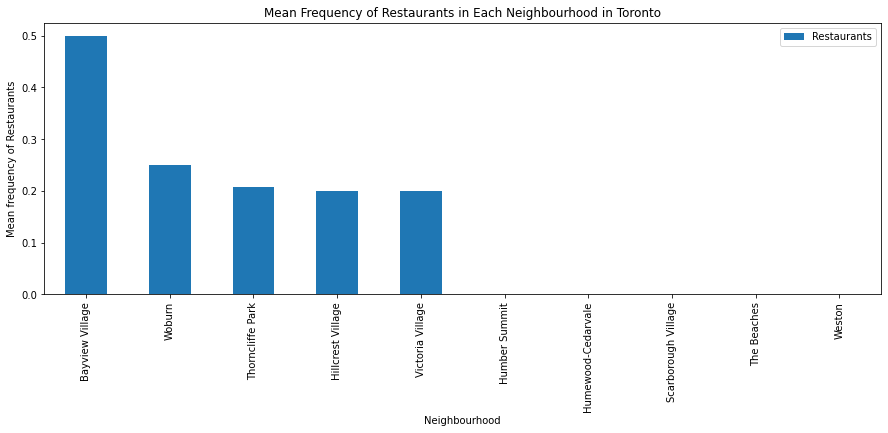

In [20]:
# Distribution of restaurant in Toronto
toronto_grouped.sort_values(by='Restaurants', ascending=False, inplace=True)

toronto_grouped.plot(kind='bar', figsize=(15,5))

plt.title('Mean Frequency of Restaurants in Each Neighbourhood in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Restaurants')

In [40]:
toronto_final_data = pd.merge(df, toronto_grouped, on='Neighbourhood')
toronto_final_data.drop(['Total Population','   Africa'], axis=1, inplace=True)
toronto_final_data.head()

,Latitude,Longitude,Neighbourhood,Income,Percentage of Africans,Restaurants
0,43.756303,-79.565963,Humber Summit,53272.0,0.322165,0.000000
1,43.725882,-79.315572,Victoria Village,43743.0,1.227870,0.200000
2,43.803762,-79.363452,Hillcrest Village,57682.0,0.177158,0.200000
3,43.786947,-79.385975,Bayview Village,58028.0,0.116844,0.500000
4,43.705369,-79.349372,Thorncliffe Park,38645.0,1.089634,0.208333


### Cluster the Neighbourhoods

In [42]:
# Normalization of our dataset
X = toronto_final_data.values[:,3:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.33091934, -0.55051031, -0.85669715],
       [-0.66394764,  0.90943249,  0.40469743],
       [ 0.79134157, -0.78425235,  0.40469743],
       [ 0.8274654 , -0.88147514,  2.29678928],
       [-1.19619991,  0.68660497,  0.45725553],
       [ 2.17730643, -1.06982121, -0.85669715],
       [-0.08878527, -0.50875576, -0.85669715],
       [-0.91316031,  2.28988248, -0.85669715],
       [-0.22910443, -0.46705743,  0.72004607],
       [-1.03583517,  0.37595226, -0.85669715]])

In [44]:
df_normal= pd.DataFrame(Clus_dataSet)
df_normal.rename(columns={0:'Income', 1:'% African', 2:'Restaurants'}, inplace=True)
df_normal.head()

,Income,% African,Restaurants
0,0.330919,-0.550510,-0.856697
1,-0.663948,0.909432,0.404697
2,0.791342,-0.784252,0.404697
3,0.827465,-0.881475,2.296789
4,-1.196200,0.686605,0.457256


#### Finding the optimal number of clusters, k

So, how can we choose right value for K? The general solution is to reserve a part of your data for testing the accuracy of the model. Then chose k =1, use the training part for modeling, and calculate the accuracy of prediction using all samples in your test set. Repeat this process, increasing the k, and see which k is the best for your model.

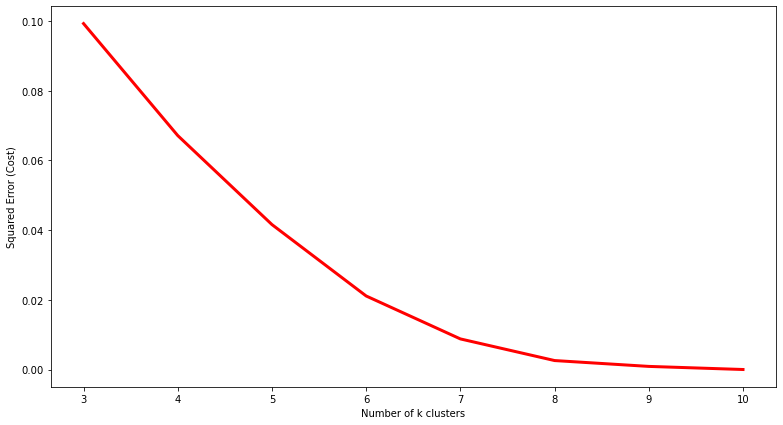

In [45]:
error_cost=[]

for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(df_normal)

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

#### By observing the graph, it appears that the optimal number of clusters is 6

### Clustering the Toronto Neighborhood Using K-Means with K = 6

In [46]:
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_normal)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 2, 1, 5, 2, 0, 3, 4, 1, 2], dtype=int32)

#### A new Dataframe with the clusters

In [52]:
df_cluster = pd.merge(df, df_normal, left_index=True, right_index=True)
df_cluster.insert(0, 'Cluster Label', kmeans.labels_)
df_cluster.head()

,Cluster Label,Latitude,Longitude,Neighbourhood,Income,Africa,Total Population,Percentage of Africans,Restaurants
0,3,43.756303,-79.565963,Humber Summit,53272.0,40.0,12416.0,0.322165,-0.856697
1,2,43.725882,-79.315572,Victoria Village,43743.0,215.0,17510.0,1.227870,0.404697
2,1,43.803762,-79.363452,Hillcrest Village,57682.0,30.0,16934.0,0.177158,0.404697
3,5,43.786947,-79.385975,Bayview Village,58028.0,25.0,21396.0,0.116844,2.296789
4,2,43.705369,-79.349372,Thorncliffe Park,38645.0,230.0,21108.0,1.089634,0.457256


### Mapping of the clusters 

In [54]:
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11)

# set color schemes for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cluster['Latitude'], df_cluster['Longitude'], df_cluster['Neighbourhood'], df_cluster['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examination of Clusters

#### Cluster 0

In [63]:
df_cluster.loc[df_cluster['Cluster Label'] == 0]

,Cluster Label,Latitude,Longitude,Neighbourhood,Income,Africa,Total Population,Percentage of Africans,Restaurants
5,0,43.676357,-79.293031,The Beaches,70957.0,0.0,21567.0,0.0,-0.856697


#### Cluster 1

In [64]:
df_cluster.loc[df_cluster['Cluster Label'] == 1]

,Cluster Label,Latitude,Longitude,Neighbourhood,Income,Africa,Total Population,Percentage of Africans,Restaurants
2,1,43.803762,-79.363452,Hillcrest Village,57682.0,30.0,16934.0,0.177158,0.404697
8,1,43.770992,-79.216917,Woburn,47908.0,200.0,53485.0,0.373937,0.720046


#### Cluster 2

In [65]:
df_cluster.loc[df_cluster['Cluster Label'] == 2]

,Cluster Label,Latitude,Longitude,Neighbourhood,Income,Africa,Total Population,Percentage of Africans,Restaurants
1,2,43.725882,-79.315572,Victoria Village,43743.0,215.0,17510.0,1.227870,0.404697
4,2,43.705369,-79.349372,Thorncliffe Park,38645.0,230.0,21108.0,1.089634,0.457256
9,2,43.744734,-79.239476,Scarborough Village,40181.0,150.0,16724.0,0.896915,-0.856697


#### Cluster 3

In [66]:
df_cluster.loc[df_cluster['Cluster Label'] == 3]

,Cluster Label,Latitude,Longitude,Neighbourhood,Income,Africa,Total Population,Percentage of Africans,Restaurants
0,3,43.756303,-79.565963,Humber Summit,53272.0,40.0,12416.0,0.322165,-0.856697
6,3,43.693781,-79.428191,Humewood-Cedarvale,49252.0,50.0,14365.0,0.348068,-0.856697


#### Cluster 4

In [67]:
df_cluster.loc[df_cluster['Cluster Label'] == 4]

,Cluster Label,Latitude,Longitude,Neighbourhood,Income,Africa,Total Population,Percentage of Africans,Restaurants
7,4,43.706876,-79.518188,Weston,41356.0,375.0,17992.0,2.08426,-0.856697


#### Cluster 5

In [68]:
df_cluster.loc[df_cluster['Cluster Label'] == 5]

,Cluster Label,Latitude,Longitude,Neighbourhood,Income,Africa,Total Population,Percentage of Africans,Restaurants
3,5,43.786947,-79.385975,Bayview Village,58028.0,25.0,21396.0,0.116844,2.296789


## IV. Conclusion & Discussion

The results of our analysis show 6 clusters whose important characteristics are as follows:

Cluster 0: in this group the African population is not present and therefore cannot bring any interest in our project

Cluster 1: this group is characterized by an African population of less than 1% but incomes in these neighborhoods are high

Cluster 2: this group is characterized by an African population of 1% on average with average incomes and the presence of restaurants in the districts of Victoria Village and Thorncliffe Park.

Cluster 3: this is characterized by high incomes but a low African population and almost no restaurants.

Cluster 4: the highest African population in the city for an average income and almost no restaurant.

Cluster 6: for this group, smaller African population but with a high density of restaurants.

From this analysis, it appears the best location for an sub-saharan african restaurant is the Neighbourhood of **Weston** which therefore wins the **The Battle of Neighbourhood**

To complete this analysis, it would be interesting to have the origin of Africans in each Neighborhood, which would allow us to have the type of African cuisine appropriate for our restaurant.
In addition, data on local food markets could also help us to find locations near these markets where we could get supplies.